In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import warnings
import imblearn
import pydot

from collections import Counter

from imblearn.over_sampling import ADASYN, SMOTE

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import layers
from tensorflow.keras import losses

from keras.callbacks import ModelCheckpoint

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
train_data= pd.read_csv('data_train.csv')
train_data.dropna(axis = 0, how ='any',inplace=True) 


train_data['Num_words_text'] = train_data['review'].apply(lambda x:len(str(x).split())) 
mask = train_data['Num_words_text'] >2
train_data = train_data[mask]

print('-------Train data--------')
print(train_data['sentiment'].value_counts())
print(len(train_data))
max_train_sentence_length  = train_data['Num_words_text'].max()

test_data= pd.read_csv('data_test.csv')
test_data.dropna(axis = 0, how ='any',inplace=True) 
test_data['Num_words_text'] = test_data['review'].apply(lambda x:len(str(x).split())) 

max_test_sentence_length  = test_data['Num_words_text'].max()

mask = test_data['Num_words_text'] >2
test_data = test_data[mask]

print('-------Test data--------')
print(test_data['sentiment'].value_counts())
print(len(test_data))
print('-------------------------')

print('Train Max Sentence Length :'+str(max_train_sentence_length))
print('Test Max Sentence Length :'+str(max_test_sentence_length))

#all_sentences = train_data['text'].tolist() + test_data['text'].tolist()

-------Train data--------
1    7743
0     755
Name: sentiment, dtype: int64
8498
-------Test data--------
1    1905
0     222
Name: sentiment, dtype: int64
2127
-------------------------
Train Max Sentence Length :1206
Test Max Sentence Length :383


In [3]:
num_words = 20000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['review'].tolist())

# print(str(tokenizer.texts_to_sequences(['nice spot hang friend see also sunset amazing beside many option restaurant choose along'])))

In [4]:
train_data.drop(["Date", "Content", "scores", "compound"], axis=1, inplace=True)

In [5]:
train_data['review'].values.astype('U')
vec = TfidfVectorizer(stop_words='english')
resp = vec.fit_transform(train_data['review'])
# print(resp)

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['review'].tolist(),\
                                                      train_data['sentiment'].tolist(),\
                                                      test_size=0.2,\
                                                      stratify = train_data['sentiment'].tolist(),\
                                                      random_state=0)

print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

# sm = SMOTE()
# try :
#     x_train_res, y_train_res = sm.fit_resample(X_train, y_train)
# except ValueError:
#     pass


x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['review'].tolist()) )

#Normal
# x_train = pad_sequences(x_train, padding='post', maxlen=1210)
# x_valid = pad_sequences(x_valid, padding='post', maxlen=1210)
# x_test = pad_sequences(x_test, padding='post', maxlen=390)

#Undersampling
x_train = pad_sequences(x_train, padding='post', maxlen=1210)
x_valid = pad_sequences(x_valid, padding='post', maxlen=1210)
x_test = pad_sequences(x_test, padding='post', maxlen=390)

print(x_train[0])

le = LabelEncoder()

# train_reviews = le.fit_transform(x_train)
# train_reviews = np.asarray( tf.keras.utils.to_categorical(train_reviews))
# #print(train_labels)
# valid_reviews = le.transform(x_valid)
# valid_reviews = np.asarray( tf.keras.utils.to_categorical(valid_reviews))

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
#print(train_labels)
valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(test_data['sentiment'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

Train data len:6798
Class distributionCounter({1: 6194, 0: 604})
Valid data len:1700
Class distributionCounter({1: 1549, 0: 151})


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[36 68 96 ...  0  0  0]


In [7]:
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Text to number
[1 1 1 1 1 1 1 1 1 1]
Number to category
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [8]:
# count =0
# print('======Train dataset ====')
# for value,label in train_ds:
#     count += 1
#     print(value,label)
#     if count==2:
#         break
# count =0
# print('======Validation dataset ====')
# for value,label in valid_ds:
#     count += 1
#     print(value,label)
#     if count==2:
#         break
# print('======Test dataset ====')
# for value,label in test_ds:
#     count += 1
#     print(value,label)
#     if count==2:
#         break

In [9]:
max_features =20000
embedding_dim =64
sequence_length = 1210

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))                                    

model.add(tf.keras.layers.Conv1D(128,2, padding='valid', activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))                               


model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Flatten())

# model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(64, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001)))

# model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(64, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001)))

# model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(2, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001)))

# custom_early_stopping = EarlyStopping(
#     monitor='val_loss', 
#     patience=1, 
#     min_delta=0.001, 
#     mode='auto'
# )
                               

model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=["CategoricalAccuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1210, 64)          1280064   
_________________________________________________________________
conv1d (Conv1D)              (None, 1209, 128)         16512     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1

In [10]:
import graphviz

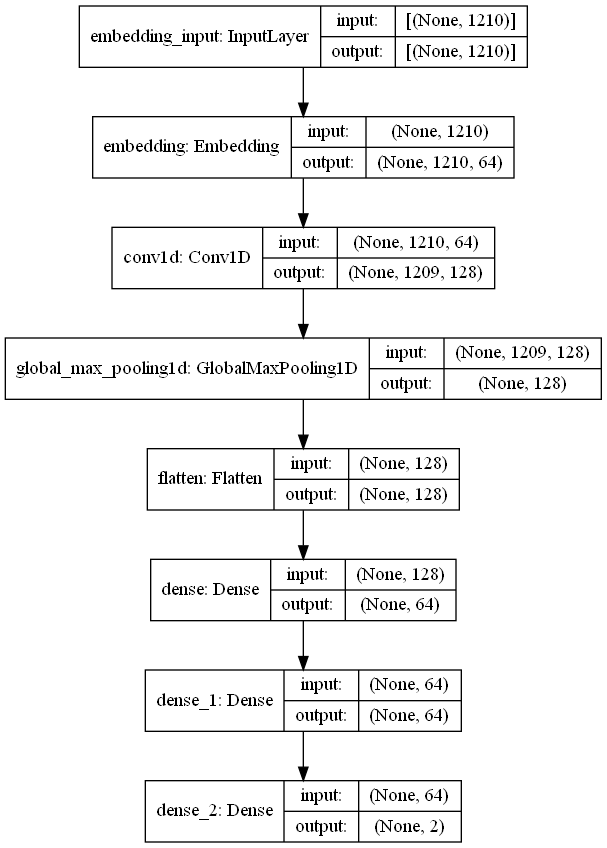

In [11]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [12]:
epochs = 3
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(2000).batch(64),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(64),
                    verbose=1)

# ,
#                     callbacks=[custom_early_stopping]

Epoch 1/3


E:\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


107/107 [==============================] - 31s 281ms/step - loss: 0.5575 - categorical_accuracy: 0.8954 - val_loss: 0.3608 - val_categorical_accuracy: 0.9112
Epoch 2/3
107/107 [==============================] - 30s 277ms/step - loss: 0.3081 - categorical_accuracy: 0.9122 - val_loss: 0.2776 - val_categorical_accuracy: 0.9241
Epoch 3/3
107/107 [==============================] - 30s 276ms/step - loss: 0.2350 - categorical_accuracy: 0.9366 - val_loss: 0.2519 - val_categorical_accuracy: 0.9294


In [13]:
len(history.history['loss'])

3

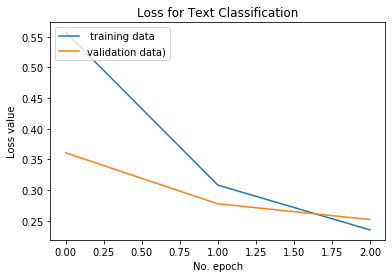

In [14]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

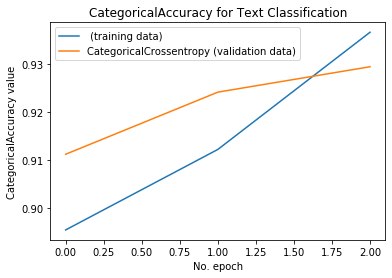

In [15]:
plt.plot(history.history['categorical_accuracy'], label=' (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='CategoricalCrossentropy (validation data)')
plt.title('CategoricalAccuracy for Text Classification')
plt.ylabel('CategoricalAccuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [16]:
model.save('newmodel4\\tf_cnnmodel') 
json_string = tokenizer.to_json()

INFO:tensorflow:Assets written to: newmodel4\tf_cnnmodel\assets


In [17]:
import json
# with open('tf_cnnmodel', 'w') as outfile:
#     json.dump(json_string, outfile)

In [18]:
new_model = tf.keras.models.load_model('newmodel4\\tf_cnnmodel')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1210, 64)          1280064   
_________________________________________________________________
conv1d (Conv1D)              (None, 1209, 128)         16512     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1

In [19]:
test_data = pd.read_csv('data_test.csv', converters={'reviews' : str})
# test_data.drop(["Date", "Content"], axis=1, inplace=True)
# test_data.fillna(0)
# test_data = test_data.fillna("")
test_data.sample(5)

,Date,Content,review,scores,compound,sentiment
837,12-Jun,"So beautiful, but we had watched Jaws the nigh...",beautiful watch jaw night wimped anything past...,"{'neg': 0.0, 'neu': 0.672, 'pos': 0.328, 'comp...",0.5994,1
777,13-Nov,Very clean. Whiter sand than Kuta beach. Not t...,clean whiter sand kuta many people easy enter ...,"{'neg': 0.0, 'neu': 0.672, 'pos': 0.328, 'comp...",0.9042,1
1790,16-Mar,this spot is nice & clean. also it is public a...,spot nice clean public many activity spot wave...,"{'neg': 0.0, 'neu': 0.443, 'pos': 0.557, 'comp...",0.8316,1
1882,16-Feb,We didn't surf at Seminyak beach but walked it...,didnt surf seminyak walk lot great run area lo...,"{'neg': 0.208, 'neu': 0.685, 'pos': 0.107, 'co...",-0.5200,0
720,19-May,Most beaches are dirty and unclean at Bali And...,beach dirty unclean bali rocky mont cant swim ...,"{'neg': 0.343, 'neu': 0.657, 'pos': 0.0, 'comp...",-0.6407,0


In [20]:
try:
    x_test  = np.array( tokenizer.texts_to_sequences(test_data['review'].tolist()) )
    # x_test = tokenizer
    x_test = pad_sequences(x_test, padding='post', maxlen=1210)
except AttributeError:
    pass

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [21]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
predictions = new_model.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)

Generate predictions for all samples
[[0.1282945  0.9192416 ]
 [0.06880724 0.9640453 ]
 [0.11001402 0.9335675 ]
 ...
 [0.09739599 0.94405556]
 [0.6170088  0.36726338]
 [0.20416683 0.85132897]]


In [22]:
test_data['pred_sentiment'] = predict_results
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == 0),'0',test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '1'),'1',test_data.pred_sentiment)

In [23]:
labels = ['0', '1']
    
print(classification_report(test_data['sentiment'].values.astype(int).astype(str),test_data['pred_sentiment'].values,labels=labels))

              precision    recall  f1-score   support

           0       0.68      0.31      0.43       222
           1       0.92      0.98      0.95      1905

    accuracy                           0.91      2127
   macro avg       0.80      0.65      0.69      2127
weighted avg       0.90      0.91      0.90      2127



In [28]:
# sentiment = ['negative','positive']
sequence20 = tokenizer.texts_to_sequences(['beautiful beach'])


test20 = pad_sequences(sequence20, padding="post")
labels[np.around(new_model.predict(test20)).argmax(axis=1)[0]]

'1'

In [25]:
sequence30 = tokenizer.texts_to_sequences(['rubbish everywhere'])


test30 = pad_sequences(sequence30, padding="post")
labels[np.around(new_model.predict(test30)).argmax(axis=1)[0]]

'0'

In [26]:
# df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])

confusion_matrix = pd.crosstab(test_data['sentiment'], test_data['pred_sentiment'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted   0     1
Actual             
0          69   153
1          32  1873


In [27]:
roc_auc = roc_auc_score(test_data['sentiment'], test_data['pred_sentiment'])

print("ROC AUC Score")
print(roc_auc)

ROC AUC Score
0.6470064552741719
